$\color{red}{\text{Notebook 3 synthmorph shapes contains a code that utilizes voxelmorph library to transform the images without}}$
$\color{red}{\text{training the model on skin images, but with training it on MNIST dataset and use it for inference on other types of images.}}$

$\color{red}{\text{Lab members:}}$
- $\color{red}{\text{Abdelrahman Usama Gabr Abdou Habib}}$

In [1]:
# This demo showcases SynthMorph, a learning strategy for training contrast
# invariant image registration networks without using acquired data. Further
# information is availabe at: https://w3id.org/synthmorph
#
# If you find our work useful, please consider citing:
#
#     SynthMorph: learning contrast-invariant registration without acquired images.
#     Hoffmann M, Billot B, Greve DN, Iglesias JE, Fischl B, Dalca AV.
#     IEEE Transactions on Medical Imaging (TMI), 41 (3), 543-558, 2022.
#     https://doi.org/10.1109/TMI.2021.3116879
#     https://arxiv.org/abs/2004.10282
#
# This notebook is distributed under the "2-clause BSD" license:
# https://choosealicense.com/licenses/bsd-2-clause

In [ ]:
# # Packages from GitHub - uncomment and install once.
# !pip -q install git+https://github.com/adalca/pystrum.git
# !pip -q install git+https://github.com/adalca/neurite.git
# !pip -q install git+https://github.com/voxelmorph/voxelmorph.git

You should consider upgrading via the 'C:\Users\abdal\Documents\Master\EMJMD MAIA\SEMESTER 3 - UdG\MIRA\code\env\Scripts\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\abdal\Documents\Master\EMJMD MAIA\SEMESTER 3 - UdG\MIRA\code\env\Scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import neurite as ne
import voxelmorph as vxm
from PIL import Image

  0%|                             | 0/40 [00:00<?, ?it/s]

100%|████████████████████| 40/40 [00:19<00:00,  2.03it/s]


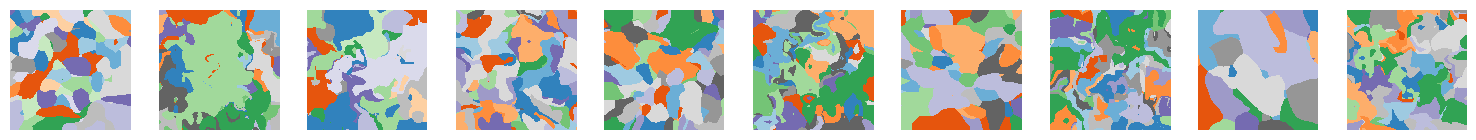

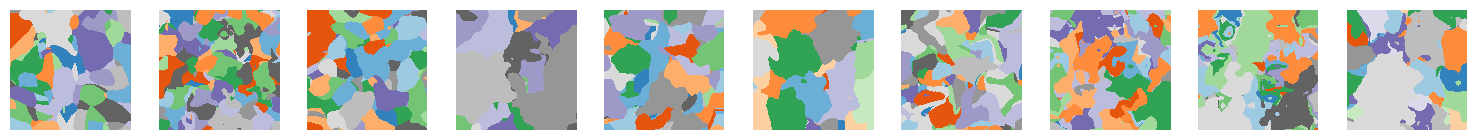

In [2]:
# Input shapes.
in_shape = (256,) * 2
num_dim = len(in_shape)
num_label = 16
num_maps = 40

# Shape generation.
label_maps = []
for _ in tqdm.tqdm(range(num_maps)):
    # Draw image and warp.
    im = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label),
        scales=(32, 64), max_std=1,
    )
    warp = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label, num_dim),
        scales=(16, 32, 64), max_std=16,
    )

    # Transform and create label map.
    im = vxm.utils.transform(im, warp)
    lab = tf.argmax(im, axis=-1)
    label_maps.append(np.uint8(lab))


# Visualize shapes.
num_row = 2
per_row = 10
for i in range(0, num_row * per_row, per_row):
    ne.plot.slices(label_maps[i:i + per_row], cmaps=['tab20c'])

C:\Users\abdal\Documents\Master\EMJMD MAIA\SEMESTER 3 - UdG\MIRA\code\env\lib\site-packages\neurite\tf\models.py:758: UserWarning: model `labels_to_image` is deprecated in favor `labels_to_image_new`
  warnings.warn('model `labels_to_image` is deprecated in favor `labels_to_image_new`')


1/1 [==============================] - 0s 33ms/step


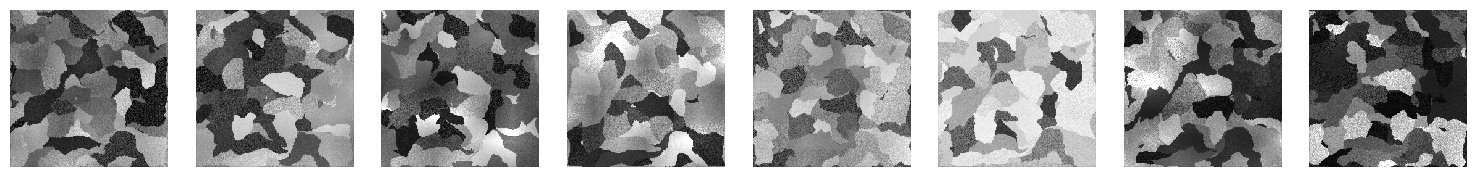

In [3]:
# Image generation. For accurate registration, the landscape of generated warps
# and image contrasts will need to include the target distribution.
gen_arg = dict(
    in_shape=in_shape,
    in_label_list=np.unique(label_maps),
    warp_std=3,
    warp_res=(8, 16, 32),
)
gen_model_1 = ne.models.labels_to_image(**gen_arg, id=1)
gen_model_2 = ne.models.labels_to_image(**gen_arg, id=2)


# Test repeatedly for single input.
num_gen = 8
input = np.expand_dims(label_maps[0], axis=(0, -1))
slices = [gen_model_1.predict(input)[0] for _ in range(num_gen)]
ne.plot.slices(slices);

In [4]:
# Registration model.
reg_model = vxm.networks.VxmDense(
    inshape=in_shape,
    int_resolution=2,
    svf_resolution=2,
    nb_unet_features=([256] * 4, [256] * 8),
    reg_field='warp',
)


# Model for optimization.
ima_1, map_1 = gen_model_1.outputs
ima_2, map_2 = gen_model_2.outputs

_, warp = reg_model((ima_1, ima_2))
pred = vxm.layers.SpatialTransformer(fill_value=0)((map_1, warp))

inputs = gen_model_1.inputs + gen_model_2.inputs
out = (map_2, pred)
model = tf.keras.Model(inputs, out)


# Compilation.
model.add_loss(vxm.losses.Dice().loss(*out) + tf.repeat(1., tf.shape(pred)[0]))
model.add_loss(vxm.losses.Grad('l2', loss_mult=1).loss(None, warp))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [5]:
in_shape

(256, 256)

In [44]:
np.array(label_maps).shape

(40, 256, 256)

In [49]:
np.array(label_maps)[0,:,:]

array([[ 9,  9,  9, ...,  2,  2,  2],
       [ 9,  9,  9, ...,  2,  2,  2],
       [ 9,  9,  9, ...,  2,  2,  2],
       ...,
       [10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 10, 10]], dtype=uint8)

Epoch 1/10
100/100 [==============================] - 93s 925ms/step - loss: 0.2254
Epoch 2/10
100/100 [==============================] - 92s 921ms/step - loss: 0.2161
Epoch 3/10
100/100 [==============================] - 92s 918ms/step - loss: 0.2166
Epoch 4/10
100/100 [==============================] - 93s 925ms/step - loss: 0.2178
Epoch 5/10
100/100 [==============================] - 92s 924ms/step - loss: 0.2349
Epoch 6/10
100/100 [==============================] - 94s 935ms/step - loss: 0.2237
Epoch 7/10
100/100 [==============================] - 94s 942ms/step - loss: 0.2081
Epoch 8/10
100/100 [==============================] - 93s 927ms/step - loss: 0.2156
Epoch 9/10
100/100 [==============================] - 93s 932ms/step - loss: 0.2181
Epoch 10/10
100/100 [==============================] - 94s 940ms/step - loss: 0.2090


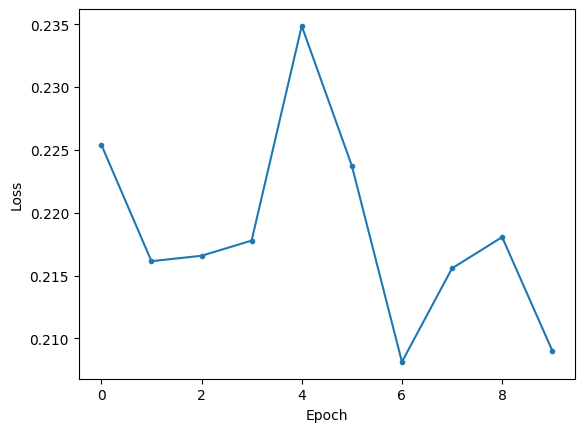

In [23]:
# Train model for a few epochs. Re-running the cell will continue training.
gen = vxm.generators.synthmorph(
    label_maps,
    batch_size=1,
    same_subj=True,
    flip=True,
)

hist = model.fit(
    gen,
    initial_epoch=0,
    epochs=10,
    steps_per_epoch=100,
    verbose=1,
)


# Visualize loss.
plt.plot(hist.epoch, hist.history['loss'], '.-');
plt.xlabel('Epoch');
plt.ylabel('Loss');

In [ ]:
# # Download model weights to skip training and save time.
# !gdown -O weights.h5 1xridvtyEWgWsWJPYVrQfDCtSgbj2beRz
# model.load_weights('weights.h5')

In [28]:
# Conform test data.
def conform(x, in_shape=in_shape):
    '''Resize and normalize image.'''
    x = np.float32(x)
    x = np.squeeze(x)
    x = ne.utils.minmax_norm(x)
    x = ne.utils.zoom(x, zoom_factor=[o / i for o, i in zip(in_shape, x.shape)])
    return np.expand_dims(x, axis=(0, -1))

1/1 [==============================] - 0s 287ms/step
(1, 256, 256, 1) (1, 256, 256, 1)


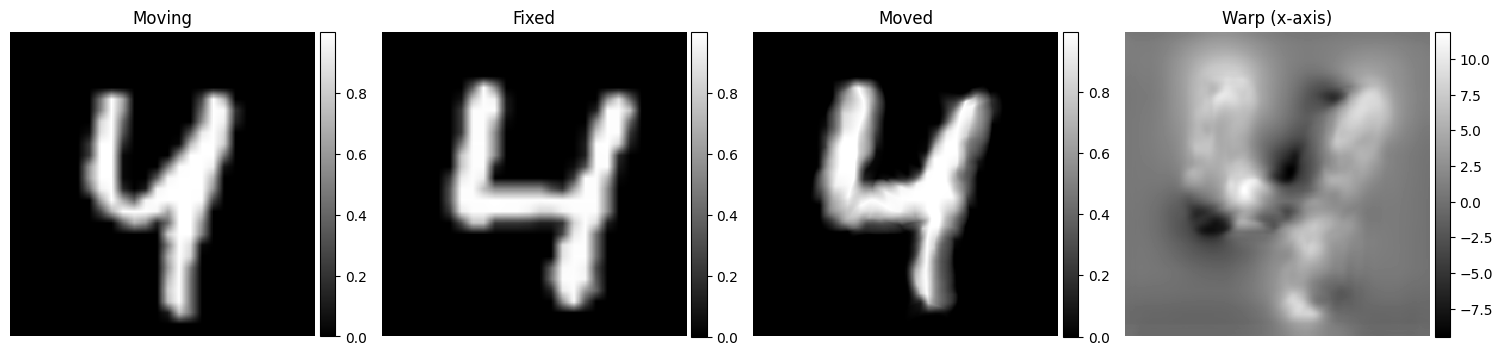

In [29]:
# Test on MNIST.
images, digits = tf.keras.datasets.mnist.load_data()[-1]
ind = np.flatnonzero(digits == 4)
moving = conform(images[ind[6]])
fixed = conform(images[ind[9]])
moved, warp = reg_model.predict((moving, fixed))

print(moving.shape, fixed.shape)


ne.plot.slices(
    slices_in=(moving, fixed, moved, warp[..., 0]),
    titles=('Moving', 'Fixed', 'Moved', 'Warp (x-axis)'),
    do_colorbars=True,
);

1/1 [==============================] - 0s 281ms/step
(1, 256, 256, 1) (1, 256, 256, 1)
0.97583294 0.0


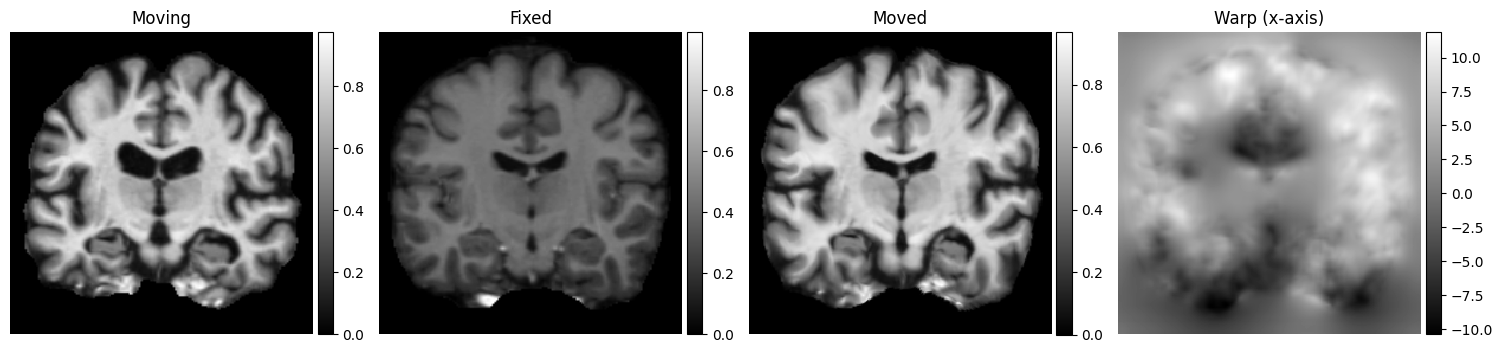

In [30]:
# Test on OASIS-1.
images = ne.py.data.load_dataset('2D-OASIS-TUTORIAL')
moving = conform(images[2])
fixed = conform(images[7])
moved, warp = reg_model.predict((moving, fixed))

print(moving.shape, fixed.shape)
print(moving.max(), fixed.min())

ne.plot.slices(
    slices_in=(moving[:, :,:,:], fixed, moved, warp[..., 0]),
    titles=('Moving', 'Fixed', 'Moved', 'Warp (x-axis)'),
    do_colorbars=True,
);

(1, 256, 256, 1) (1, 256, 256, 1)
1.0 0.0
1/1 [==============================] - 0s 297ms/step


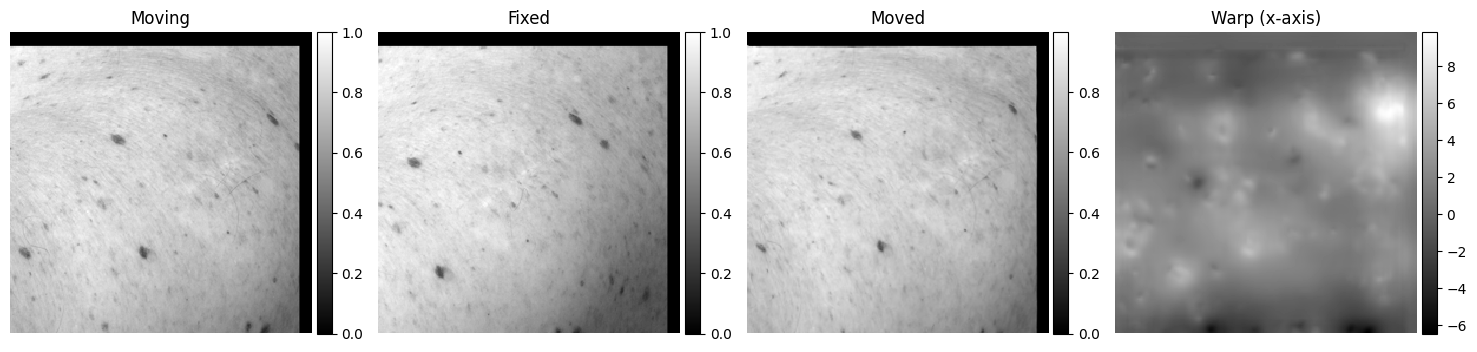

In [41]:
# File paths for moving and fixed images
moving_directory = './moving/skin1.png'
fixed_directory = './fixed/skin2.png'

# Test on skin images
moving = conform(np.expand_dims(np.array(Image.open(moving_directory).convert('L').resize((256, 256))), axis=(0, 3)))
fixed = conform(np.expand_dims(np.array(Image.open(fixed_directory).convert('L').resize((256, 256))), axis=(0, 3)))

print(moving.shape, fixed.shape)
print(moving.max(), fixed.min())

moved, warp = reg_model.predict((moving, fixed))

ne.plot.slices(
    slices_in=(moving, fixed, moved, warp[..., 0]),
    titles=('Moving', 'Fixed', 'Moved', 'Warp (x-axis)'),
    do_colorbars=True,
);